# _On Measuring the Intrinsic Few-Shot Hardness of Datasets_ and Beyond

While reproducing the paper _On Measuring the Intrinsic Few-Shot Hardness of
Datasets_ would require too much time given the necessity of writing an adapter
for each combination of task and method, we can streamline this process using
[Huggingface Transformers](https://huggingface.co/docs/transformers/index).
While this means that we cannot use the exact same methods as the authors used,
this should not matter given the their premise. Namely that datasets have some
intrinsic hardness. This would also allow us to run the same experiments with a
variety of different models, including LLaMA 2. Given that `bert-base-uncased`
(as used by the authors in the original paper) has not had any safety training,
it cannot be used for experiments involving jailbreaking. Therefore, this setup
is necessary as it will allow me to perform a 'sanity check' in the form of
reproducing results similar to the ones shown in the paper, and extend from it
using a safety-enabled model.

## Methodology

This script has been developed run locally with Python 3.12, and on Google Colab
which uses Python 3.10 at the time of writing. Locally, I would recommend using
`conda` to ensure that no conflicts or unexpected behaviors arise when running
these experiments.

### Setting Up the Environment

In [34]:
def in_colab():
    import sys
    return "google.colab" in sys.modules

if in_colab():
    # to use accelerate in google colab, we need to update transformers to the
    # latest version
    !pip install -q datasets evaluate torch peft wandb
    !pip install -q transformers -U
    !pip install -q accelerate -U

In [35]:
import importlib

try:
    import ifh
    import data
    import methods
except ModuleNotFoundError or ImportError:
    if in_colab():
        print("Could not find ifh.py; downloading from GitHub repository...")

        # we're not cloning the complete repository, as it's quite large
        !wget -q https://raw.githubusercontent.com/cochaviz/mep/experiments/src/replicating_ifh/ifh.py
        !wget -q https://raw.githubusercontent.com/cochaviz/mep/experiments/src/replicating_ifh/data.py
        !wget -q https://raw.githubusercontent.com/cochaviz/mep/experiments/src/replicating_ifh/methods.py

        import ifh
        import data
        import methods
    else:
        raise ImportError("Could not find ifh.py; please make sure to clone the complete repository")
finally:
    # reloading is nice when trying to debug as it allows to change the code 
    # without needing to restart the kernel
    importlib.reload(ifh)
    importlib.reload(data)
    importlib.reload(methods)

    from ifh import run as run_ifh
    from ifh import CustomArguments, TrainingArgumentsCustomDefaults

    from methods import Methods
    from data import fs_glue_tasks

rng_seed = 42

/home/zohar/.conda/envs/ifh/lib/python3.12/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [38]:
# I would strongly recommend using wandb to log the results of the experiments
# especially when working in Google Colab as you don't have to download your
# results all the time
import wandb
wandb.login()

if not in_colab():
    !wandb offline

 ________________________________________ 
/ A classic is something that everyone   \
| wants to have read and nobody wants to |
| read.                                  |
|                                        |
| -- Mark Twain, "The Disappearance of   |
\ Literature"                            /
 ---------------------------------------- 
        \   ^__^
         \  (oo)\_______
            (__)\       )\/\
                ||----w |
                ||     ||
wandb: wandb: Is a directory


### Running the Experiments

The code to run a single instance of the experiment can be found in `ifh.py`.
This script will run each combination of the specified methods and tasks, and
report the performance. I personally like using _Weights and Biases_ for which
this script will do nice formatting, but other similar services should work as
everything is done through Huggingface Transformers. For more information on the
available methods and tasks, refer to the `data.py` and `methods.py` scripts.

In [39]:
print("Available tasks:", fs_glue_tasks)
print("Available models:", Methods.list_available())

Available tasks: ['cola', 'mrpc', 'qqp', 'mnli', 'qnli', 'rte', 'sst2', 'boolq', 'cb', 'copa', 'wic']
Available models: ['lora', 'adam', 'baseline']


In [ ]:
import time

current_time = time.strftime("%Y-%m-%d-%H-%M-%S")
n_runs = 5

for run in range(n_runs):
    run_ifh(
        args=CustomArguments(
            model_name="bert-base-uncased",

            # we want the same train/test split for all runs
            train_test_split_shuffle_seed=rng_seed,

            # use all available
            methods=["baseline"], 
            tasks=None,   

            # we want different few-shot subset of the training data for each
            # run
            few_shot_sample_seed=run * rng_seed,
            few_shot_samples=64,
        ),
        training_args=TrainingArgumentsCustomDefaults(
            # The parameter output_dir here has a slightly different meaning
            # than default. Here, it's used to indicate the top-level directory
            # for the collective training results. The individual runs will be
            # stored in subdirectories of this directory.
            output_dir=f"{current_time}/{run * rng_seed}",
            learning_rate=1e-5,
            num_train_epochs=5,
            seed=rng_seed,
            report_to="all"
        )
    )

## Results

### Replicating _On Measuring..._

This section aims to replicate the analysis as found in the paper using the
results as provided by `heatmap_raw_data.json`. We will use the functions and
terminology defined here to extend the analysis in the next subsection.

In [9]:
import json
import pandas as pd
import seaborn as sns
import numpy as np
import os

sns.set_theme(context="notebook", style="whitegrid", palette="muted")

In [10]:
if not os.path.exists("heatmap_raw_data.json"):
    !wget -q https://raw.githubusercontent.com/colinzhaoust/intrinsic_fewshot_hardness/main/heatmap_raw_data.json

with open("heatmap_raw_data.json", "r", encoding="utf-8") as f:
    raw_data = json.load(f)
   
# fine-tuning tasks performance
acc_raw = raw_data["output_collection"]
acc_baseline_raw = raw_data["majority_collection"]
acc_electra_raw = raw_data["output_collection_electra"]

# dataset metadata
n_samples_test = raw_data["testsize_collection"]

# final hidden layer data - data to calculate spread
all_dist_collections = raw_data["all_dist_collections"]

In [11]:
# drop these as they are not 'accuracy of one model after finetuning'
# which is what we need
fine_tuned_acc = pd.DataFrame(acc_raw) \
    .drop(["sensitivity", "rda", "few-avg"], axis="columns") / 100.0

baseline_acc = pd.DataFrame(
    { "baseline": list(acc_baseline_raw.values()) }
    , index=list(acc_baseline_raw.keys()) )

# make sure all values are on a scale of [0.0, 1.0]
baseline_acc_scaled = baseline_acc.where(baseline_acc <= 1.0, baseline_acc / 100.0 )
all_acc = pd.concat([fine_tuned_acc, baseline_acc_scaled], axis="columns")

# I'm not sure what to do with tasks that contain NaN values. They seem in
# appropriate to include since we cannot compare all of them with one another.
clean_acc = all_acc.dropna()

display(all_acc.head(10))

,manual,lmbff,nullp,bitfit,adapet,ptuning,adapter,compacter,roberta,roberta-zero,baseline
anaphora,0.5030,0.503,0.479,0.493,0.542,0.521,0.582,0.507,0.500,0.493,0.51
boolean,0.9830,0.697,0.717,0.742,0.820,0.806,0.936,0.722,0.726,0.629,0.73
comparative,0.5240,0.485,0.459,0.470,0.867,0.648,0.573,0.563,0.648,0.648,0.65
conditional,0.6210,0.977,0.717,0.680,1.000,0.662,1.000,0.662,0.662,0.662,0.66
counting,0.8500,0.852,0.819,0.858,0.938,0.905,0.894,0.796,0.662,0.338,0.66
event,0.6250,0.676,0.617,0.654,0.871,0.613,0.697,0.606,0.500,0.507,0.50
gender,0.5700,0.613,0.543,0.522,0.805,0.509,0.509,0.519,0.500,0.509,0.50
lexico_syntactic,0.6530,0.699,0.489,0.515,0.656,0.517,0.501,0.488,0.513,0.512,0.51
monotonicity,0.4830,0.782,0.611,0.578,0.801,0.694,0.670,0.556,0.671,0.329,0.67
monotonicity_simple,0.5715,0.725,0.629,0.590,0.566,0.675,0.666,0.667,0.667,0.332,0.67


### Method Specific Few-Shot Hardness

Here, we will define the _Method Specific Few-Shot Hardness_ (MFH) and perform
the analysis shown in the paper. That is, we will "report the average
spearman correlation between MFH values for all pairs of adapation methods for
every dataset". MFH is defined as "the classification accuracy of the adapted
model, normalized against the classification accuracy of the majority baseline":

$$
\mathrm{MFH}(\mathcal{D}, f, m) = \mathrm{acc}( f_m(\mathcal{D}_{tr}),
\mathcal{D}_{ts}) - \mathrm{acc}( \hat{y}_{majority}(\mathcal{D}_{tr}), \mathcal{D}_{ts} )
$$

Here, $\hat{y}_{majority}$, refers to 'an approximation of the classifier based
on majority vote'. This metric will, thus, determine the accuracy of the model
after fine-tuning on dataset $\mathcal{D}$. I'll be honest that I don't
understand what _hardness_ refers to, but I'll come back to the semantics of
hardness in a later section.

In [12]:

def df_with_columns(df: pd.DataFrame, columns: list[str] | None) -> pd.DataFrame:
    return df[df.columns[df.columns.isin(columns)]] if columns else df

def df_with_indexes(df: pd.DataFrame, indexes: list[str] | None) -> pd.DataFrame:
    return df.loc[df.index.isin(indexes)] if indexes else df

def df_with(df, 
            indexes: list[str] | None = None, 
            columns: list[str] | None = None
            ) -> pd.DataFrame:
    return df_with_indexes(df_with_columns(df, columns), indexes)

def mfh(data) -> pd.DataFrame:
    return data.sub(data["baseline"], axis="index").drop("baseline", axis="columns")

def mfh_avg(data, include_tasks: list[str] | None = None) -> pd.DataFrame:
    mfh_data = mfh(data)
    mfh_data = df_with_indexes(mfh_data, include_tasks)

    molten = mfh_data.melt(
        id_vars=None, 
        value_vars=mfh_data.columns.to_list(), 
        var_name="method", 
        value_name="acc_norm")
    return molten.groupby("method").mean()

all_mfh = mfh(all_acc)
display(all_mfh.head(10))

,manual,lmbff,nullp,bitfit,adapet,ptuning,adapter,compacter,roberta,roberta-zero
anaphora,-0.0070,-0.007,-0.031,-0.017,0.032,0.011,0.072,-0.003,-0.010,-0.017
boolean,0.2530,-0.033,-0.013,0.012,0.090,0.076,0.206,-0.008,-0.004,-0.101
comparative,-0.1260,-0.165,-0.191,-0.180,0.217,-0.002,-0.077,-0.087,-0.002,-0.002
conditional,-0.0390,0.317,0.057,0.020,0.340,0.002,0.340,0.002,0.002,0.002
counting,0.1900,0.192,0.159,0.198,0.278,0.245,0.234,0.136,0.002,-0.322
event,0.1250,0.176,0.117,0.154,0.371,0.113,0.197,0.106,0.000,0.007
gender,0.0700,0.113,0.043,0.022,0.305,0.009,0.009,0.019,0.000,0.009
lexico_syntactic,0.1430,0.189,-0.021,0.005,0.146,0.007,-0.009,-0.022,0.003,0.002
monotonicity,-0.1870,0.112,-0.059,-0.092,0.131,0.024,0.000,-0.114,0.001,-0.341
monotonicity_simple,-0.0985,0.055,-0.041,-0.080,-0.104,0.005,-0.004,-0.003,-0.003,-0.338


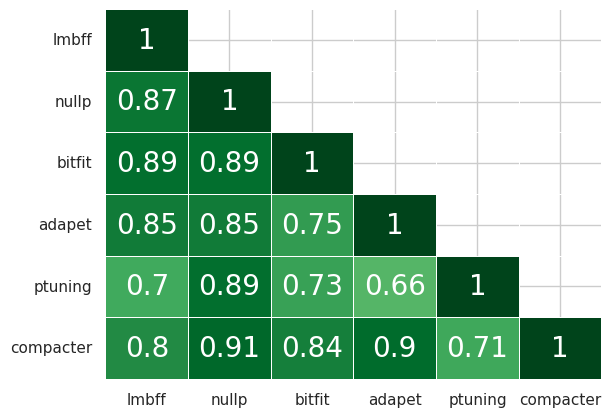

In [13]:
def draw_heatmap(df, **opts):
    sns.heatmap(
        df, annot=True, vmax=1, center=0.6, cbar=False, square=False,
        linewidths=.5, cbar_kws={"shrink": .5}, annot_kws={"fontsize":120 / len(df) },
        cmap="Greens", **opts
    )

def draw_corr(df, method: str="spearman"):
    corr = df.corr(method=method).round(2)
    mask = np.triu(np.ones_like(corr, dtype=bool), k=1)
    draw_heatmap(corr, mask=mask)

# these are the methods used in the paper to produce 'Figure 3' as found in the
# appendix.
included_methods = ["lmbff", "nullp", "bitfit", 
                    "adapet", "ptuning", "compacter",
                    "baseline"]
included_tasks = ["cola", "sst2", "mrpc", "qqp", 
                  "mnli", "qnli", "rte", "boolq", 
                  "cb", "copa", "wic"]

included_acc = df_with(all_acc, indexes=included_tasks, columns=included_methods)
included_mfh = mfh(included_acc)

draw_corr(included_mfh)

Which is exactly the result as presented in their paper, but I'm not sure what
exactly this is telling us. Firstly, let's look at the scatterplot of one pair
with an explicitly high correlation: $\mathrm{compacter}$ and $\mathrm{nullp}$.

Spearman's correlation between 'compacter' and 'nullp': 0.9090909090909091


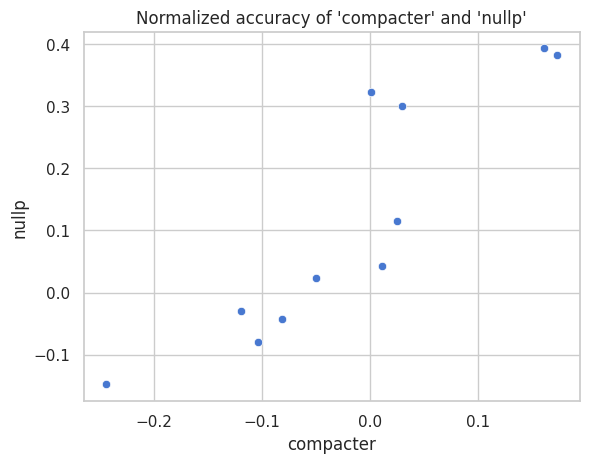

In [14]:
sns.scatterplot(
    data=included_mfh, x="compacter", y="nullp"
    ).set_title("Normalized accuracy of 'compacter' and 'nullp'")

corr = included_mfh.corr(method="spearman")["compacter"]["nullp"]
print("Spearman's correlation between 'compacter' and 'nullp':", corr)

We can see that, indeed, a monotonic correlation is there. Essentially, if we
see a strong correlation we can expect that models will improve similarly when
comparing one task with another. Not to the same magnitude, as different methods
might have slightly different success rates, but if certain tasks are
'significantly' harder than others, we would expect some monotonic relation when
the values are sorted. As can be seen above.

### Beyond _On Measuring..._

Doing multiple sets of runs where we sample different training examples, gives
us, in this case, two sets of results: `adam` and `lora` on a seed of 0, and
`adam` and `lora` on a seed of 42 [^1]. We can then add these to the results
found in the original paper and then generate the same correlation matrix.

[^1]: Actually, in one run I used the _uncased_ version of Bert and in the other
    the _cased_ version. While this is a variable that should ideally not be
    introduced, I think my point still stands although this should be redone in
    the future. 

In [30]:
from collections import defaultdict

def collect_local_raw(output_dir="results", model="bert-base-uncased"):
    tasks = defaultdict(list)
    accuracy = defaultdict(list)

    for root, dirs, files in os.walk(os.path.join(output_dir, model)):
        if "evaluation.json" in files:
            task = root.split("/")[-1]
            method = root.split("/")[-2]

            evaluation = json.load(open(os.path.join(root, "evaluation.json"), "r"))

            try:
                acc = evaluation["eval_accuracy"]
            except KeyError:
                acc = evaluation["accuracy"]

            accuracy[method].append(acc)
            tasks[method].append(task)

    results = pd.DataFrame()

    for method in tasks.keys():
        method_results = pd.DataFrame({  method : accuracy[method] }, index=tasks[method])
        results = pd.concat([ results, method_results ], axis="columns")

    results.sort_index(inplace=True)
    return results

def collect_wandb(output_dir: str, model="bert-base-uncased"):
    api = wandb.Api()
    runs = api.runs("cochaviz/ifh", { "config.collection": output_dir } )

    results = pd.DataFrame()

    for run in runs:
        method = run.config["method"]
        task = run.config["task"]
        acc = run.summary.get("eval/accuracy")

        if not acc or np.isnan(acc):
            acc = run.summary.get("accuracy")

        if method not in results.columns:
            results[method] = np.nan

        results.at[task, method] = acc
    
    results.sort_index(inplace=True)
    return results

# I saved the results locally to a json file after processing them a bit
hf_acc = pd.read_json("mfh_1709029260245748247.json")

display(hf_acc.head(10))

,adam_0,lora_0,adam_42,lora_42,baseline
boolq,0.628000,0.628000,0.570312,0.578125,0.628000
cb,0.410714,0.410714,0.660714,0.500000,0.410714
cola,0.691275,0.687440,0.664062,0.664062,0.691275
copa,0.550000,0.510000,0.510000,0.430000,0.550000
mnli,0.350000,0.312000,0.445312,0.460938,0.301500
mrpc,0.615196,0.671569,0.664062,0.664062,0.316176
qnli,0.515500,0.515500,0.468750,0.468750,0.515500
qqp,0.621500,0.482000,0.718750,0.718750,0.654000
rte,0.519856,0.476534,0.562500,0.570312,0.527076
sst2,0.490826,0.490826,0.539062,0.539062,0.490826


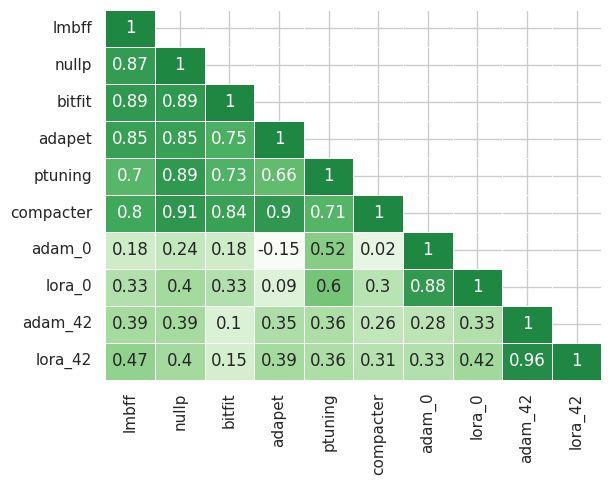

In [32]:
assert set(hf_acc.index.to_list()) == set(included_acc.index.to_list())

# calculate mfh separately because baselines are different
hf_mfh = pd.concat([
    mfh(included_acc), 
    mfh(hf_acc)
    ], axis="columns")

draw_corr(hf_mfh)

As we can see, there are no strong correlations between the methods introduced
in the original results and my own. Even when comparing two different runs of my
own introduced methods, we see relatively low correlations, although they are
still present. However, if we look at grouped runs (notice the subscript in
`adam` and `lora`), we see very strong correlations within these groups. The
only variable here is the seed used when drawing a few-shot sample from the
training set. 

While I cannot attest that I have used the same evaluation set as
the original authors did, this result does suggest that, indeed datasets have
some intrinsic hardness. Here, however, a _dataset_ specifically refers to the
few-shot subset of the training set that was generated from the complete
dataset. At least, this is what the data seems to suggest to me. Given the large
discrepancy between the average inter-group correlation and intra-group
correlation, I think the few-shot sample carries more weight in determining the
difficulty of a task than hardness of the complete dataset. At least, in the
case of `bert-base-uncased`.

This all rests on the implicit assumption that the same 64 samples were used on
when training using the different fine-tuning methods in the original results.
This, however, is neither confirmed or denied by the authors in the main text
body or the appendix. I have written to the authors to ask whether they can
confirm my suspicion, but I do not think the assumption is unreasonable.

#### Detour - Improved Normalization of MFH

In the current normalization, improvements over the baseline are counted equal
regardless of the value of the baseline. This means that a 5% increase in a
baseline of 50% is equal to a 5% increase in a baseline of 90%. Considering the
asymptotic relation normally found in learning scenarios, this can introduce
inconsistencies when comparing normalized accuracies of methods on tasks with
different baseline values.

To reflect the characteristic of an asymptotic learning curve, I scale the
original normalization by the inverse of the baseline. That is:

$$
\frac{
    \mathrm{Accuracy} - \mathrm{Accuracy}_{\mathrm{base}}
}{
    1 - \mathrm{Accuracy}_{\mathrm{base}}
}
$$

Where $acc$ is the to be normalized accuracy and $acc_{base}$ the baseline
accuracy. This means that an accuracy of $1.0$ will remain as 'perfectly
accurate' regardless of the baseline, while values equal to the baseline will be
zero and accuracies under the baseline will still be zero. The characteristic of
values under the baseline leave something to be desired, but as we currently
have no combination of methods and tasks where that is the case, this does not
seem relevant to this particular use-case.

In [ ]:
def mfh_imp(data) -> pd.DataFrame:
    """
    An improved version of the baseline accuracy where perfectly accurate
    is still 1.0, instead of 1 - baseline.
    """
    return mfh(data).div((1.0 - data["baseline"]), axis="index")

def mfh_avg(data, imp=False) -> pd.DataFrame:
    mfh_data = mfh(data) if not imp else mfh_imp(data)
    molten = mfh_data.melt(
        id_vars=None, 
        value_vars=mfh_data.columns.to_list(), 
        var_name="method", 
        value_name="acc_norm")
    return molten.groupby("method").mean()

<!-- We would expect this only to matter in task-to-task comparisons. In the case of
method-to-method comparisons, the baseline is equal and thus the scaling has no
effect on the normalized accuracy between methods. This means that if we
calculate the Pearson correlation between the different methods within a certain
task, we should expect the same results regardless of using `mfh` or `mfh_imp`. -->

Now, let's look at the same scatterplot and Spearman's correlation as before and see how it influenced the results.

Before, after, and difference between default and improved normalization:
0.9090909090909091 0.9545454545454546 -0.045454545454545525


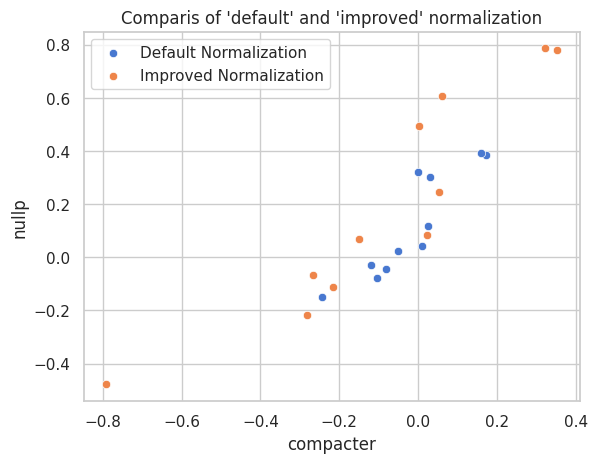

In [ ]:
sns.scatterplot(data=mfh(min_acc), x="compacter", y="nullp", label="Default Normalization")
sns.scatterplot(
    data=mfh_imp(min_acc), x="compacter", y="nullp", label="Improved Normalization"
    ).set_title("Comparis of 'default' and 'improved' normalization")

corr_def = mfh(min_acc).corr(method="spearman")["compacter"]["nullp"]
corr_imp = mfh_imp(min_acc).corr(method="spearman")["compacter"]["nullp"]
print("Before, after, and difference between default and improved normalization:")
print(corr_def, corr_imp, corr_def - corr_imp)

And finally the heatmap discussed before.

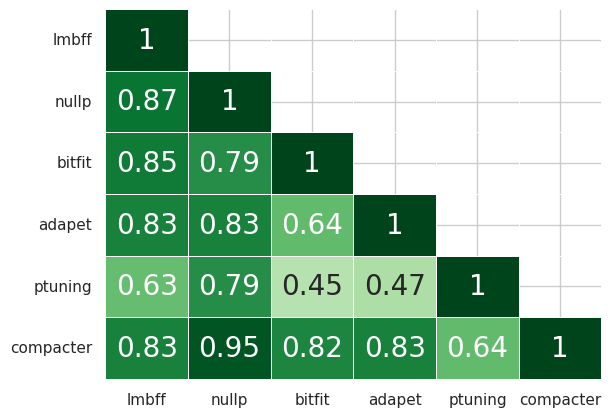

In [ ]:
draw_corr(mfh_imp(min_acc))

### Intrinsic Few-Shot Hardness

Now that we have established some correlation between the different
methodologies - that is: there is a monotonic trend when comparing
the accuracy of these methods on different tasks - we would like to see in more
explicit terms that some tasks are indeed harder than others. To do this, the
authors establish a metric called the _Intrinsic Few-Shot Hardness_.

$$
\mathrm{IFH}(f, \mathcal{D}) = \frac
{
    \sum_{m\in\mathcal{M}}\mathrm{MFH}(\mathcal{D}, f, m)
}{
    | \mathcal{M} |
}
$$

This is essentially the average improvement we see in a certain task when
considering all the methods.

In [ ]:
def ifh(data: pd.DataFrame, imp=False) -> pd.DataFrame:
    return pd.DataFrame(mfh(data).mean(axis="columns"), columns=["ifh"]) if not imp \
        else pd.DataFrame(mfh_imp(data).mean(axis="columns"), columns=["ifh"])

min_ifh = ifh(min_acc).sort_values("ifh")
min_ifh_imp = ifh(min_acc, imp=True).sort_values("ifh")

display(min_ifh)
display(min_ifh_imp)

,ifh
cola,-0.157467
qqp,-0.128633
copa,-0.035800
mrpc,0.012783
boolq,0.028833
wic,0.034433
rte,0.107583
mnli,0.188867
qnli,0.196183
sst2,0.290230


,ifh
cola,-0.509436
qqp,-0.349357
copa,-0.079556
mrpc,0.038046
wic,0.068867
boolq,0.076218
rte,0.227497
mnli,0.289628
qnli,0.396570
sst2,0.591305


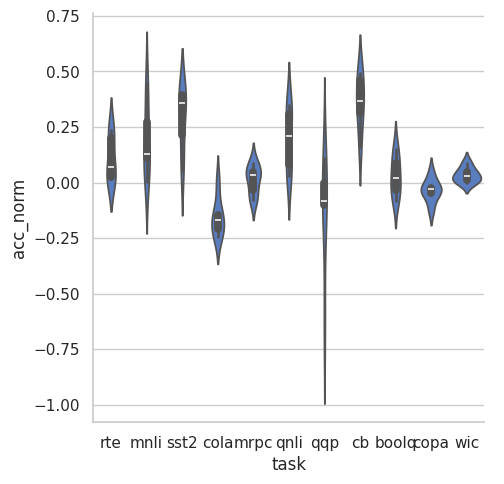

In [ ]:
mfh_molt = mfh(min_acc).reset_index().rename(columns={"index": "task"}).melt(
    id_vars="task", value_vars=mfh(min_acc).columns.to_list(), 
    var_name="method", value_name="acc_norm"
)

mfh_molt_imp = mfh_imp(min_acc).reset_index().rename(columns={"index": "task"}).melt(
    id_vars="task", value_vars=mfh(min_acc).columns.to_list(), 
    var_name="method", value_name="acc_norm"
)

sns.catplot(mfh_molt, x="task", y="acc_norm", kind="violin")

# _ = sns.displot(data=mfh_molt, x="acc_norm", hue="task", kind="kde", fill=True)
# _ = sns.displot(data=mfh_molt_imp, x="acc_norm", hue="task", kind="kde", fill=True)